In [1]:
# https://github.com/ourownstory/neural_prophet
  
# article    
# https://towardsdatascience.com/neural-prophet-a-time-series-modeling-library-based-on-neural-networks-dd02dc8d868d

#example
# https://github.com/e-alizadeh/medium/blob/master/notebooks/NeuralProphet/neural_prophet.ipynb

In [3]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

from neuralprophet import NeuralProphet

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
import matplotlib.dates as mdates

from sklearn.metrics import mean_absolute_error
from collections import Counter

-------------------------------------- DATA from GRAFANA --------------------------------------

In [4]:
path = '/mnt/files/workdata/work/docker-containers/mysql-with-data-for-grafana-v2/'
df_full = pd.read_csv(path + "v2_grafana-operations.csv")#, parse_dates=["ds"]

In [5]:
# df_full_copy = df_full.copy()

In [6]:
df_full = df_full_copy.copy()

In [7]:
Counter(df_full.status)

Counter({'failure': 3038270, 'success': 10282369, 'error': 1411})

In [8]:
print(str(Counter(df_full.currency)))

Counter({'UAH': 4673196, 'USD': 2845175, 'RUB': 1666301, 'EUR': 1060336, 'MDL': 1018500, 'KZT': 538965, 'ILS': 257737, 'PLN': 189941, 'GBP': 173436, 'CAD': 165185, 'RON': 148722, 'CHF': 104453, 'MXN': 72608, 'AUD': 57461, 'COP': 55520, 'ZAR': 38925, 'GEL': 30057, 'PEN': 28511, 'RSD': 25424, 'TRY': 22298, 'CZK': 21201, 'BRL': 20577, 'DKK': 17652, 'AED': 11688, 'BYN': 11249, 'AZN': 9070, 'NOK': 9050, 'SAR': 7696, 'ARS': 7077, 'HUF': 6705, 'THB': 6068, 'NGN': 4089, 'HRK': 3925, 'BGN': 3843, 'MYR': 1966, 'INR': 1856, 'QAR': 1630, 'SEK': 1493, 'EGP': 1008, 'UZS': 628, 'KGS': 543, 'CLP': 187, 'JPY': 94, 'PHP': 2, 'KRW': 2})


In [9]:
str(list(df_full))

"['id', 'order_id', 'type', 'status', 'amount', 'currency', 'terminal_id', 'mcc', 'project_id', 'created', 'card_masked', 'expiration_year', 'expiration_month', 'country', 'zip', 'bank_name', 'card_type', 'merchant_id']"

In [10]:
# Counter(df_full.terminal_id)

In [11]:
# merchant_id - сгенерировали сами, он не нужен для анализа
col_names = ['amount', 'created','currency', 'terminal_id', 'mcc', 'project_id', 'card_masked',  'country',  'bank_name', 'card_type']

mask = (df_full.type == 'charge') & (df_full.status == 'success') & (df_full.currency == 'EUR')


df_eur_e13 = df_full[mask][col_names].copy()

In [12]:
dt =  df_eur_e13.copy()

In [13]:
print(dt.shape)
print('min=', min(dt['created']), ' max= ', max(dt['created']))

# mask = dt.created < '2020-03-15'
# dt = dt[mask].copy()

(319289, 10)
min= 2020-01-01 00:00:59  max=  2020-03-25 23:58:26


In [14]:
data_agg = 'date_hour'
dt[data_agg] = dt['created'].str[:13]#16 -wwith minutes
dt['date_only'] = dt['created'].str[:10]#16 -wwith minutes

In [175]:
def plot_points(forecast, date_test='2020-03-15'):
    mask = forecast.ds > date_test
    forecast_sub = forecast[mask].copy()

    fig, ax = plt.subplots(figsize=(24, 5)) 
    ax.scatter(x = forecast_sub['ds'], y = forecast_sub['y1'], c='DarkBlue',marker='.')

    ax.plot(forecast_sub['ds'],forecast_sub['yhat1'] , linestyle='dashed', color='green')#
    # ax.plot(forecast_sub['ds'],forecast_sub['yhat2'], linestyle='dashed', color='grey')#

    ax.scatter(x = forecast_sub['ds'], y = forecast_sub['anomaly_point'], c='RED', marker='.', s=64)
    ax.set_title("Amount по дате", fontsize=10, fontweight="bold")#"Amount by date"

    plt.xlabel("Date")
    plt.ylabel("Amount")

    plt.legend([ "neuralprophet предсказание",  "фактические значения", 'аномальные значения'], loc ='upper right')
    # plt.legend([ "neuralprophet предсказание", "среднее по 5-ти предидущим значениям", "фактические значения", 'аномальные значения'], loc ='upper right')


    plt.show()

In [16]:
dt.head()

,amount,created,currency,terminal_id,mcc,project_id,card_masked,country,bank_name,card_type,date_hour,date_only
57,9.90,2020-01-01 00:00:59,EUR,e13884801c21bdd62ec3ce85cab03f8b45a41ea1,5399,224f3d3120309f994e744af6ed64dddc18a82888,535876******5100,ESP,undefined,MasterCard,2020-01-01 00,2020-01-01
73,69.99,2020-01-01 00:01:11,EUR,a14f2bc450bd3e5d116ebf93785e8b1d45a5eee4,8641,f161302002d4d92168c951d25b8e2598f64e5ee1,431940******7605,IRL,ROYAL BANK OF SCOTLAND PLC,VISA card,2020-01-01 00,2020-01-01
85,1.95,2020-01-01 00:01:24,EUR,f2924025f3527aadd3db16463a54eb3e9603e59e,7298,b3cf5250cf7e57b079d691c9b7572e38e63c7987,402360******6448,ITA,POSTE ITALIANE S.P.A. (BANCO POSTA),VISA card,2020-01-01 00,2020-01-01
268,6.24,2020-01-01 00:05:07,EUR,9a664dfa0f1e64b81c8cfb23c4a331a2b9694f24,7273,039f62b24257c47697c4888592671f86d79b930c,436618******9879,USA,"U.S. BANK, N.A.",VISA card,2020-01-01 00,2020-01-01
314,4.48,2020-01-01 00:06:08,EUR,e13884801c21bdd62ec3ce85cab03f8b45a41ea1,5399,224f3d3120309f994e744af6ed64dddc18a82888,406439******3072,MKD,STOPANSKA BANKA A.D. SKOPJE,VISA card,2020-01-01 00,2020-01-01


In [375]:
def calculate_anomay(dt_sub, date_test='2020-03-19 00', periods = 7*24, data_agg='date_hour'):
    
    dt_agg = dt_sub.groupby(data_agg).agg({'amount': ['sum','count']})

    dt_agg.reset_index(inplace=True)
    dt_agg.columns = ['ds', 'y', 'n']

    mask = dt_agg.ds >= date_test

    dt_agg_test = dt_agg[mask].copy()
    dt_agg = dt_agg[~mask].copy()

    model = NeuralProphet(
    #     n_changepoints=200,
        changepoints_range=0.90,    
    )

    col_names = ['ds','y']
    metrics = model.fit(dt_agg[col_names], freq="H", validate_each_epoch=True, valid_p=0.2) 
    future = model.make_future_dataframe(dt_agg[col_names], periods=periods, n_historic_predictions=dt_agg.shape[0])

    forecast = model.predict(future)
    dt_agg_test['ds'] = pd.to_datetime(dt_agg_test['ds'] )
        
    forecast.rename(columns={"y": "y1"}, inplace=True)
    forecast = pd.merge(forecast, dt_agg_test, how='left', left_on='ds', right_on='ds')
    
    forecast.y1 = np.where(forecast.y1.isnull(), forecast.y, forecast.y1 )
    forecast.y1.fillna(0, inplace=True)
    
    y_std = forecast.y.std()
    mask = (forecast.y1 - forecast.yhat1 > 1.5* y_std ) | ( forecast.y1 - forecast.yhat1 < -y_std* 1.2 ) 
    
    forecast['anomaly_point'] = np.where(mask, forecast.y1, np.NAN)    
    forecast['std_deviation'] = np.where(mask,(forecast.y1 - forecast.yhat1)/y_std  , np.NAN)
    
    return forecast


In [421]:
dt.country.fillna('undefined', inplace=True)

In [477]:
# amomaly_day = '2020-02-02 00'# '2020-03-19 00'
start_test = '2020-02-02 00'# '2020-03-19 00'

In [500]:
forecast = calculate_anomay(dt,date_test=start_test)

/home/sergey/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
INFO: nprophet.utils - set_auto_seasonalities: Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 52


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 5.34E-01
Epoch[52/52]: 100%|██████████| 52/52 [00:03<00:00, 14.61it/s, SmoothL1Loss=0.0174, MAE=2.4e+3, RegLoss=0, MAE_val=3.49e+3, SmoothL1Loss_val=0.044]  


In [479]:
forecast.tail()

,ds,y1,yhat1,residual1,trend,season_weekly,season_daily,y,n,anomaly_point,std_deviation
931,2020-02-08 19:00:00,18411.47,9120.552734,NaN,7913.966797,-2227.270264,3433.856445,18411.47,206.0,NaN,NaN
932,2020-02-08 20:00:00,10106.84,8095.735352,NaN,7911.233398,-2253.366211,2437.867432,10106.84,179.0,NaN,NaN
933,2020-02-08 21:00:00,16245.45,7871.137695,NaN,7908.500977,-2267.064209,2229.701172,16245.45,203.0,NaN,NaN
934,2020-02-08 22:00:00,15074.98,7516.198242,NaN,7905.767578,-2268.506592,1878.937012,15074.98,171.0,NaN,NaN
935,2020-02-08 23:00:00,7357.72,5453.574707,NaN,7903.034180,-2257.944336,-191.515564,7357.72,154.0,NaN,NaN


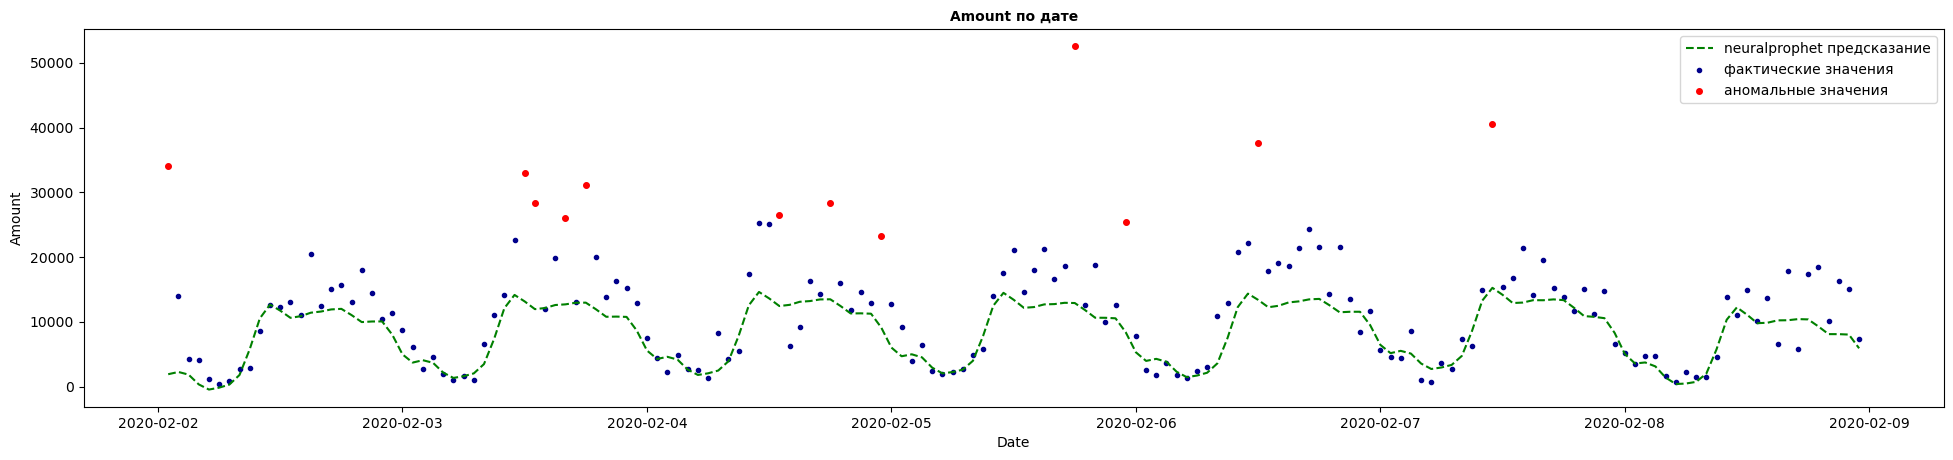

In [379]:
plot_points(forecast,date_test=start_test)

In [509]:
forecast = calculate_anomay(dt,date_test=start_test)

/home/sergey/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
INFO: nprophet.utils - set_auto_seasonalities: Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 52


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 6.58E-01
Epoch[52/52]: 100%|██████████| 52/52 [00:03<00:00, 14.79it/s, SmoothL1Loss=0.0174, MAE=2.4e+3, RegLoss=0, MAE_val=3.54e+3, SmoothL1Loss_val=0.0446] 


In [510]:

mask = (forecast.ds > amomaly_day) & (forecast.anomaly_point.notnull() )
forecast_anomaly = forecast[mask].copy()

data_agg = 'date_hour'
forecast_anomaly[data_agg] = forecast_anomaly.ds.dt.strftime('%Y-%m-%d %H')

mask = dt[data_agg].isin(forecast_anomaly[data_agg])
dt_anomaly = dt[mask]

In [514]:
forecast.head()

,ds,y1,yhat1,residual1,trend,season_weekly,season_daily,y,n,anomaly_point,std_deviation
0,2020-01-01 00:00:00,2056.58,4230.770508,2174.190508,6529.264648,672.855408,-2971.349365,NaN,NaN,NaN,NaN
1,2020-01-01 01:00:00,1720.84,2821.623535,1100.783535,6552.236328,663.593872,-4394.206543,NaN,NaN,NaN,NaN
2,2020-01-01 02:00:00,2416.03,2953.421875,537.391875,6575.208008,650.739929,-4272.526855,NaN,NaN,NaN,NaN
3,2020-01-01 03:00:00,45646.65,2488.913086,-43157.736914,6598.179688,634.325195,-4743.592285,NaN,NaN,45646.65,4.910534
4,2020-01-01 04:00:00,2903.49,1064.722900,-1838.767100,6621.152344,614.435730,-6170.865234,NaN,NaN,NaN,NaN


In [515]:
col_names = ['ds', 'std_deviation', 'n']
# min_size = int(dt.shape[0]/200)
min_size = int(dt.shape[0]/500)
# min_size = 100

# project_ids = dt.project_id.unique()
bank_ids = dt.bank_name.unique()
# bank_ids = dt_anomaly.bank_name.unique()
project_ids = dt_anomaly.project_id.unique()
card_type_ids = dt_anomaly.card_type.unique()
country_ids = dt_anomaly.country.unique()

index = 3
item_ids = [country_ids, bank_ids, card_type_ids, project_ids][index]
item =  ['country' ,'bank', 'card_type', 'pid'][index]
item_name = ['country' ,'bank_name', 'card_type', 'project_id'][index]

len_item = 15
for item_id in item_ids:
    
    mask = dt[item_name] == item_id    
    dt_sub = dt[mask].copy()
    print('id=', item_id)
    
    if dt_sub.shape[0] < min_size:# and item_id not in ['TATRA BANKA, A.S.', 'PAYLIFE BANK GMBH']:
        continue
    
    
    forecast_sub = calculate_anomay(dt_sub, date_test=start_test)
    forecast_sub= forecast_sub[col_names].copy()
    
    col_std = 'std_{}_{}' . format(item, item_id[:len_item])
    col_n = 'n_{}_{}'    .  format(item, item_id[:len_item])
    
    forecast_sub.rename(columns={"std_deviation": col_std, 'n': col_n}, inplace=True)
    
    forecast =  pd.merge(forecast, forecast_sub, how='left', left_on='ds', right_on='ds')

/home/sergey/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
INFO: nprophet.utils - set_auto_seasonalities: Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 52


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 3.51E-01
Epoch[1/52]:   0%|          | 0/52 [00:00<?, ?it/s, SmoothL1Loss=0.756, MAE=2.25e+3, RegLoss=0, MAE_val=2.67e+3, SmoothL1Loss_val=0.904]

id= 224f3d3120309f994e744af6ed64dddc18a82888


Epoch[52/52]: 100%|██████████| 52/52 [00:03<00:00, 14.83it/s, SmoothL1Loss=0.00756, MAE=182, RegLoss=0, MAE_val=185, SmoothL1Loss_val=0.00682]    
/home/sergey/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
INFO: nprophet.utils - set_auto_seasonalities: Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 114


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.85E-01
Epoch[2/114]:   0%|          | 0/114 [00:00<?, ?it/s, SmoothL1Loss=0.219, MAE=1.35e+3, RegLoss=0, MAE_val=1.96e+3, SmoothL1Loss_val=0.355]

id= 1c7b5bb4b349fc11ee42503d4e53338dce7d8482
id= fe79f81d11c5d1cb31dd5507154f1e69c779d560


Epoch[114/114]: 100%|██████████| 114/114 [00:03<00:00, 30.92it/s, SmoothL1Loss=0.0592, MAE=612, RegLoss=0, MAE_val=777, SmoothL1Loss_val=0.102]     
/home/sergey/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
INFO: nprophet.utils - set_auto_seasonalities: Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 52


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 3.51E-02
Epoch[1/52]:   0%|          | 0/52 [00:00<?, ?it/s, SmoothL1Loss=1.08, MAE=5.81e+3, RegLoss=0, MAE_val=4.74e+3, SmoothL1Loss_val=0.811]

id= 3e1c59c70af87dc024c29c35e42b5320a5a4cc93


Epoch[52/52]: 100%|██████████| 52/52 [00:03<00:00, 14.75it/s, SmoothL1Loss=0.0167, MAE=528, RegLoss=0, MAE_val=529, SmoothL1Loss_val=0.0176]     
/home/sergey/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
INFO: nprophet.utils - set_auto_seasonalities: Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 88


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 4.33E-01
Epoch[2/88]:   0%|          | 0/88 [00:00<?, ?it/s, SmoothL1Loss=0.304, MAE=207, RegLoss=0, MAE_val=148, SmoothL1Loss_val=0.19]

id= 6be658d520acce55bdba93ccdb86dfe8e5c65a84


Epoch[88/88]: 100%|██████████| 88/88 [00:03<00:00, 24.16it/s, SmoothL1Loss=0.171, MAE=126, RegLoss=0, MAE_val=139, SmoothL1Loss_val=0.167]
/home/sergey/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
INFO: nprophet.utils - set_auto_seasonalities: Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 99


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 3.51E-01
Epoch[2/99]:   0%|          | 0/99 [00:00<?, ?it/s, SmoothL1Loss=0.0907, MAE=115, RegLoss=0, MAE_val=95.4, SmoothL1Loss_val=0.0537]

id= 039f62b24257c47697c4888592671f86d79b930c


Epoch[99/99]: 100%|██████████| 99/99 [00:03<00:00, 26.56it/s, SmoothL1Loss=0.0486, MAE=82.4, RegLoss=0, MAE_val=83.6, SmoothL1Loss_val=0.0446]
/home/sergey/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
INFO: nprophet.utils - set_auto_seasonalities: Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO: nprophet.utils - set_auto_seasonalities: Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 2
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 188


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.00E-05
Epoch[3/188]:   0%|          | 0/188 [00:00<?, ?it/s, SmoothL1Loss=0.52, MAE=922, RegLoss=0, MAE_val=937, SmoothL1Loss_val=0.544]

id= ccc9614c2213e29bedf167057785feb4417dd8c8


Epoch[188/188]: 100%|██████████| 188/188 [00:06<00:00, 31.25it/s, SmoothL1Loss=0.479, MAE=878, RegLoss=0, MAE_val=888, SmoothL1Loss_val=0.496]
/home/sergey/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
INFO: nprophet.utils - set_auto_seasonalities: Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 68


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 4.33E-01
Epoch[1/68]:   0%|          | 0/68 [00:00<?, ?it/s, SmoothL1Loss=0.474, MAE=570, RegLoss=0, MAE_val=391, SmoothL1Loss_val=0.248]

id= 454fe97686ecc4a7c524e633219d5606570acb03


Epoch[68/68]: 100%|██████████| 68/68 [00:03<00:00, 18.95it/s, SmoothL1Loss=0.0452, MAE=131, RegLoss=0, MAE_val=162, SmoothL1Loss_val=0.0701] 
/home/sergey/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
INFO: nprophet.utils - set_auto_seasonalities: Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 57


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 4.33E-01
Epoch[1/57]:   0%|          | 0/57 [00:00<?, ?it/s, SmoothL1Loss=0.755, MAE=1.02e+3, RegLoss=0, MAE_val=755, SmoothL1Loss_val=0.441]

id= 9678b87bc4e7cbb263f7c42a7eb8aa88086ad2d1


Epoch[57/57]: 100%|██████████| 57/57 [00:03<00:00, 16.54it/s, SmoothL1Loss=0.04, MAE=175, RegLoss=0, MAE_val=187, SmoothL1Loss_val=0.0449]    
/home/sergey/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
INFO: nprophet.utils - set_auto_seasonalities: Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 55


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.85E-01
Epoch[1/55]:   0%|          | 0/55 [00:00<?, ?it/s, SmoothL1Loss=0.292, MAE=381, RegLoss=0, MAE_val=138, SmoothL1Loss_val=0.0429]

id= f161302002d4d92168c951d25b8e2598f64e5ee1


Epoch[55/55]: 100%|██████████| 55/55 [00:03<00:00, 15.25it/s, SmoothL1Loss=0.0372, MAE=127, RegLoss=0, MAE_val=148, SmoothL1Loss_val=0.0479]
/home/sergey/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
INFO: nprophet.utils - set_auto_seasonalities: Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 65


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 3.51E-01
Epoch[1/65]:   0%|          | 0/65 [00:00<?, ?it/s, SmoothL1Loss=1.09, MAE=6.54e+3, RegLoss=0, MAE_val=3.19e+3, SmoothL1Loss_val=0.376]

id= 3b51cee05a380029cab7a06e876d2c006b500752


Epoch[65/65]: 100%|██████████| 65/65 [00:03<00:00, 18.25it/s, SmoothL1Loss=0.0443, MAE=976, RegLoss=0, MAE_val=1.39e+3, SmoothL1Loss_val=0.094]     
/home/sergey/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
INFO: nprophet.utils - set_auto_seasonalities: Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 56


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 4.33E-01
Epoch[1/56]:   0%|          | 0/56 [00:00<?, ?it/s, SmoothL1Loss=0.269, MAE=267, RegLoss=0, MAE_val=171, SmoothL1Loss_val=0.0977]

id= 832b06e7bdb8f1afb02c81482a988f954c071c89
id= c6fbb009ed8f91bebebf63b95c4b43cc1bf42a67


Epoch[56/56]: 100%|██████████| 56/56 [00:03<00:00, 15.39it/s, SmoothL1Loss=0.0779, MAE=117, RegLoss=0, MAE_val=128, SmoothL1Loss_val=0.0616]
/home/sergey/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
INFO: nprophet.utils - set_auto_seasonalities: Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 53


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.85E-04
Epoch[1/53]:   0%|          | 0/53 [00:00<?, ?it/s, SmoothL1Loss=0.908, MAE=278, RegLoss=0, MAE_val=265, SmoothL1Loss_val=0.85]

id= c25b6fd36ac3c5982c95d1cb65468aa40de30781


Epoch[53/53]: 100%|██████████| 53/53 [00:03<00:00, 15.02it/s, SmoothL1Loss=0.511, MAE=172, RegLoss=0, MAE_val=157, SmoothL1Loss_val=0.462]
/home/sergey/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
INFO: nprophet.utils - set_auto_seasonalities: Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 91


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E-01
Epoch[2/91]:   0%|          | 0/91 [00:00<?, ?it/s, SmoothL1Loss=0.605, MAE=2.53e+3, RegLoss=0, MAE_val=2.76e+3, SmoothL1Loss_val=0.696]

id= f0660cc875a7f0cfa90cab60dda8eef9f4121e9c


Epoch[91/91]: 100%|██████████| 91/91 [00:03<00:00, 25.17it/s, SmoothL1Loss=0.113, MAE=786, RegLoss=0, MAE_val=1.52e+3, SmoothL1Loss_val=0.341]    
/home/sergey/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
INFO: nprophet.utils - set_auto_seasonalities: Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 71


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.23E-01
Epoch[1/71]:   0%|          | 0/71 [00:00<?, ?it/s, SmoothL1Loss=0.634, MAE=1.4e+3, RegLoss=0, MAE_val=1.07e+3, SmoothL1Loss_val=0.427]

id= 832d3953a5b63bade8819226cf52146ee7c288fd
id= 82b5880791d652e6996b71c2a87818b87dd20b24


Epoch[71/71]: 100%|██████████| 71/71 [00:03<00:00, 19.76it/s, SmoothL1Loss=0.0332, MAE=230, RegLoss=0, MAE_val=247, SmoothL1Loss_val=0.0391]
/home/sergey/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
INFO: nprophet.utils - set_auto_seasonalities: Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 74


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 4.33E-02
Epoch[1/74]:   0%|          | 0/74 [00:00<?, ?it/s, SmoothL1Loss=0.851, MAE=3.68e+3, RegLoss=0, MAE_val=3.34e+3, SmoothL1Loss_val=0.76]

id= ff8c3ba0b6ad9c16bdc53fd17642e109d3d4daa2


Epoch[74/74]: 100%|██████████| 74/74 [00:03<00:00, 20.48it/s, SmoothL1Loss=0.0522, MAE=702, RegLoss=0, MAE_val=752, SmoothL1Loss_val=0.0709]     
/home/sergey/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
INFO: nprophet.utils - set_auto_seasonalities: Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 96


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 3.51E-02
Epoch[2/96]:   0%|          | 0/96 [00:00<?, ?it/s, SmoothL1Loss=0.428, MAE=95, RegLoss=0, MAE_val=101, SmoothL1Loss_val=0.451] 

id= 28fc116c49b57c0aea12e399ebfbb9fa199f86ae


Epoch[96/96]: 100%|██████████| 96/96 [00:03<00:00, 26.45it/s, SmoothL1Loss=0.0724, MAE=30, RegLoss=0, MAE_val=54.7, SmoothL1Loss_val=0.211]  
/home/sergey/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
INFO: nprophet.utils - set_auto_seasonalities: Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 115


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E-01
Epoch[2/115]:   0%|          | 0/115 [00:00<?, ?it/s, SmoothL1Loss=0.55, MAE=154, RegLoss=0, MAE_val=148, SmoothL1Loss_val=0.537]

id= 3f2c967509c80091cfb29f9cc94ddb8827450fc3


Epoch[115/115]: 100%|██████████| 115/115 [00:03<00:00, 31.29it/s, SmoothL1Loss=0.104, MAE=39.9, RegLoss=0, MAE_val=81.8, SmoothL1Loss_val=0.312]
/home/sergey/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
INFO: nprophet.utils - set_auto_seasonalities: Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 83


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.85E-01
Epoch[1/83]:   0%|          | 0/83 [00:00<?, ?it/s, SmoothL1Loss=0.771, MAE=557, RegLoss=0, MAE_val=378, SmoothL1Loss_val=0.448]

id= 6ae3b9aa54b0f1293c516e467ba98b1617f3a320


Epoch[83/83]: 100%|██████████| 83/83 [00:03<00:00, 22.31it/s, SmoothL1Loss=0.149, MAE=155, RegLoss=0, MAE_val=246, SmoothL1Loss_val=0.282]
/home/sergey/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
INFO: nprophet.utils - set_auto_seasonalities: Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 2
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 592


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.87E-01
Epoch[8/592]:   0%|          | 0/592 [00:00<?, ?it/s, SmoothL1Loss=0.179, MAE=3.19e+3, RegLoss=0, MAE_val=4.48e+3, SmoothL1Loss_val=0.309]

id= df15cba3e575416f3b867bf71793ea848249d7b3


Epoch[592/592]: 100%|██████████| 592/592 [00:07<00:00, 77.98it/s, SmoothL1Loss=0.00726, MAE=754, RegLoss=0, MAE_val=3.34e+3, SmoothL1Loss_val=0.0952]   
/home/sergey/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
INFO: nprophet.utils - set_auto_seasonalities: Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 2
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 164


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.00E-02
Epoch[2/164]:   0%|          | 0/164 [00:00<?, ?it/s, SmoothL1Loss=1.1, MAE=420, RegLoss=0, MAE_val=699, SmoothL1Loss_val=2.12] 

id= 925601ca5c49151c5f66a26fca80b1bb6edac36c


Epoch[164/164]: 100%|██████████| 164/164 [00:06<00:00, 24.99it/s, SmoothL1Loss=0.122, MAE=83.8, RegLoss=0, MAE_val=121, SmoothL1Loss_val=0.182]
/home/sergey/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
INFO: nprophet.utils - set_auto_seasonalities: Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 76


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.85E-01
Epoch[1/76]:   0%|          | 0/76 [00:00<?, ?it/s, SmoothL1Loss=0.412, MAE=1.48e+3, RegLoss=0, MAE_val=796, SmoothL1Loss_val=0.138]

id= 29b1df2cc978dad3d154593d2a439f57cdaf00a2
id= b3cf5250cf7e57b079d691c9b7572e38e63c7987


Epoch[76/76]: 100%|██████████| 76/76 [00:03<00:00, 21.18it/s, SmoothL1Loss=0.0306, MAE=322, RegLoss=0, MAE_val=399, SmoothL1Loss_val=0.035]       
/home/sergey/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
INFO: nprophet.utils - set_auto_seasonalities: Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 238


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E-01
Epoch[6/238]:   0%|          | 0/238 [00:00<?, ?it/s, SmoothL1Loss=0.105, MAE=1.25e+3, RegLoss=0, MAE_val=1.77e+3, SmoothL1Loss_val=0.204]

id= 8e7ca09b25c7e959b55c2790b6a2bdcb5d56d2cb


Epoch[238/238]: 100%|██████████| 238/238 [00:03<00:00, 61.89it/s, SmoothL1Loss=0.0444, MAE=788, RegLoss=0, MAE_val=1.16e+3, SmoothL1Loss_val=0.0806]    
/home/sergey/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
INFO: nprophet.utils - set_auto_seasonalities: Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 95


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 3.51E-01
Epoch[2/95]:   0%|          | 0/95 [00:00<?, ?it/s, SmoothL1Loss=0.496, MAE=865, RegLoss=0, MAE_val=706, SmoothL1Loss_val=0.31]        

id= 461b31c4395a879b4d590ea18bddb7731c78931f


Epoch[95/95]: 100%|██████████| 95/95 [00:03<00:00, 26.40it/s, SmoothL1Loss=0.107, MAE=292, RegLoss=0, MAE_val=356, SmoothL1Loss_val=0.157]        
/home/sergey/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
INFO: nprophet.utils - set_auto_seasonalities: Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 307


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E-01
Epoch[6/307]:   0%|          | 0/307 [00:00<?, ?it/s, SmoothL1Loss=0.229, MAE=1.34e+3, RegLoss=0, MAE_val=1.14e+3, SmoothL1Loss_val=0.187]

id= 6efe1f4bdda094f4c80053a63f4b8aa41a89fb5e
id= cadcbd9af567603269c4ead5fd632af51a284354


Epoch[307/307]: 100%|██████████| 307/307 [00:03<00:00, 77.57it/s, SmoothL1Loss=0.0708, MAE=651, RegLoss=0, MAE_val=993, SmoothL1Loss_val=0.0959]      
/home/sergey/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
INFO: nprophet.utils - set_auto_seasonalities: Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 111


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 6.58E-02
Epoch[2/111]:   0%|          | 0/111 [00:00<?, ?it/s, SmoothL1Loss=0.697, MAE=133, RegLoss=0, MAE_val=139, SmoothL1Loss_val=0.74] 

id= 5f9fd85a12166a2cdfcb4110fbdf97ec48f4baf2


Epoch[111/111]: 100%|██████████| 111/111 [00:03<00:00, 30.42it/s, SmoothL1Loss=0.0536, MAE=28.1, RegLoss=0, MAE_val=36.6, SmoothL1Loss_val=0.0641]
/home/sergey/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
INFO: nprophet.utils - set_auto_seasonalities: Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 172


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E-01
Epoch[3/172]:   0%|          | 0/172 [00:00<?, ?it/s, SmoothL1Loss=0.207, MAE=1.22e+3, RegLoss=0, MAE_val=1.11e+3, SmoothL1Loss_val=0.177]

id= 95c96cd67a174e9edbed22ee790b3ae2931a0f9d
id= 79215aaf146695b45e14e97ab2ed36d3e63e564a
id= 21abfc1194c512798ecb071ac0a71e2ae9c1b4d3
id= 578f9d2a193db043c6648bdd229cdd9d76279bc7


Epoch[172/172]: 100%|██████████| 172/172 [00:03<00:00, 45.68it/s, SmoothL1Loss=0.0952, MAE=653, RegLoss=0, MAE_val=828, SmoothL1Loss_val=0.115]       
/home/sergey/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
INFO: nprophet.utils - set_auto_seasonalities: Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 133


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 4.33E-01
Epoch[3/133]:   0%|          | 0/133 [00:00<?, ?it/s, SmoothL1Loss=0.155, MAE=120, RegLoss=0, MAE_val=97.1, SmoothL1Loss_val=0.106]

id= cc585aeeba53f4966f5fda263b7f55e27ca55ece


Epoch[133/133]: 100%|██████████| 133/133 [00:03<00:00, 35.47it/s, SmoothL1Loss=0.0792, MAE=72.8, RegLoss=0, MAE_val=81.7, SmoothL1Loss_val=0.103] 
/home/sergey/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
INFO: nprophet.utils - set_auto_seasonalities: Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 182


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 6.58E-03
Epoch[4/182]:   0%|          | 0/182 [00:00<?, ?it/s, SmoothL1Loss=0.891, MAE=116, RegLoss=0, MAE_val=112, SmoothL1Loss_val=0.854]

id= 7a38d373a7e79a5a33e0abeaafc26f96ab9399a1
id= cfac4e89373c4ccc30bf439aebf92e5b60003388


Epoch[182/182]: 100%|██████████| 182/182 [00:03<00:00, 48.73it/s, SmoothL1Loss=0.122, MAE=26.5, RegLoss=0, MAE_val=18.5, SmoothL1Loss_val=0.0338]
/home/sergey/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
INFO: nprophet.utils - set_auto_seasonalities: Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 88


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 4.33E-01
Epoch[1/88]:   0%|          | 0/88 [00:00<?, ?it/s, SmoothL1Loss=1.11, MAE=2.26e+3, RegLoss=0, MAE_val=1.23e+3, SmoothL1Loss_val=0.457]

id= f5213d04f0f312c47554f1c23d2bfdbae686c95c
id= 85e63c0059e8ad6e4257be01ef47bd22a17c43e0
id= b49719d80e37c59d32129b0ec5cd32674247ba72
id= 7fc910f3a51d89245f36b3b370fce40b9efbfc1a


Epoch[88/88]: 100%|██████████| 88/88 [00:03<00:00, 24.26it/s, SmoothL1Loss=0.0526, MAE=276, RegLoss=0, MAE_val=300, SmoothL1Loss_val=0.0504]      
/home/sergey/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
INFO: nprophet.utils - set_auto_seasonalities: Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 216


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.87E-01
Epoch[5/216]:   0%|          | 0/216 [00:00<?, ?it/s, SmoothL1Loss=0.267, MAE=561, RegLoss=0, MAE_val=521, SmoothL1Loss_val=0.192]        

id= 97e41c44469c5d2bf7eaddf9d173e35d7af7b72a
id= d816262b4b2aa834b6b4c6d989b48c03b056f2b4
id= cb9d4c6de0d1d76062d7fc356b11b8fd80b5f518
id= 51dfe45c685dbb9ac1b650122838facfb4f209f1


Epoch[216/216]: 100%|██████████| 216/216 [00:03<00:00, 55.79it/s, SmoothL1Loss=0.103, MAE=271, RegLoss=0, MAE_val=622, SmoothL1Loss_val=0.279]    


id= 0ecc5d9fcd99ab47cf889ef081e51235af41f178
id= 23ac974a20006aaee85ec3f94c3096b29a49c48e


In [516]:
mask = (forecast.ds > start_test) & (forecast.anomaly_point.notnull() )
forecast_anomaly = forecast[mask].copy()

In [517]:
str(list(forecast_anomaly))

"['ds', 'y1', 'yhat1', 'residual1', 'trend', 'season_weekly', 'season_daily', 'y', 'n', 'anomaly_point', 'std_deviation', 'std_pid_224f3d3120309f9', 'n_pid_224f3d3120309f9', 'std_pid_fe79f81d11c5d1c', 'n_pid_fe79f81d11c5d1c', 'std_pid_3e1c59c70af87dc', 'n_pid_3e1c59c70af87dc', 'std_pid_6be658d520acce5', 'n_pid_6be658d520acce5', 'std_pid_039f62b24257c47', 'n_pid_039f62b24257c47', 'std_pid_ccc9614c2213e29', 'n_pid_ccc9614c2213e29', 'std_pid_454fe97686ecc4a', 'n_pid_454fe97686ecc4a', 'std_pid_9678b87bc4e7cbb', 'n_pid_9678b87bc4e7cbb', 'std_pid_f161302002d4d92', 'n_pid_f161302002d4d92', 'std_pid_3b51cee05a38002', 'n_pid_3b51cee05a38002', 'std_pid_c6fbb009ed8f91b', 'n_pid_c6fbb009ed8f91b', 'std_pid_c25b6fd36ac3c59', 'n_pid_c25b6fd36ac3c59', 'std_pid_f0660cc875a7f0c', 'n_pid_f0660cc875a7f0c', 'std_pid_82b5880791d652e', 'n_pid_82b5880791d652e', 'std_pid_ff8c3ba0b6ad9c1', 'n_pid_ff8c3ba0b6ad9c1', 'std_pid_28fc116c49b57c0', 'n_pid_28fc116c49b57c0', 'std_pid_3f2c967509c8009', 'n_pid_3f2c967509c8

In [91]:
# col_names = ['ds','n'] + [col for col in list(forecast_anomaly) if col.startswith('std')]
# forecast_anomaly[col_names].head()

In [99]:
# col_items

In [522]:
forecast_anomaly.fillna(0, inplace=True)

n = forecast_anomaly.shape[0]
all_info = []
all_anomaly_coef = []

col_items =  [col for col in list(forecast_anomaly) if col.startswith('std') and col != 'std_deviation']
for i in range(n):
    info = {}
    n_ = forecast_anomaly['n'].values[i]
    anomaly_coef = 0
    
    for col in col_items:
        std_v = round(forecast_anomaly[col].values[i], 2)
        if not np.isnan(std_v) and std_v > 0 :
            column = 'n{}' . format(col[3:])
#             print('columnt={} i={}'.format(column, i))
            n_value = int(forecast_anomaly[column].values[i])
            
            anomaly_coef += std_v *n /100
            if n_value > 0:#n_value * 60  > n_:
                d = {'коэф. отклонения': std_v , 'кол-во': n_value}
                k_info = col[4:]
                info[k_info] = d
                
                
        
    all_info.append(info)
    all_anomaly_coef.append(anomaly_coef)

In [523]:
forecast_anomaly['info'] = all_info
forecast_anomaly['anomaly_coef'] = all_anomaly_coef

In [528]:
mask = dt.date_hour == '2020-02-04 18'#'2020-02-07 11'
tmp = dt[mask].copy()
tmp.sort_values(by='amount', ascending=False, inplace=True)
tmp.head(20)

,amount,created,currency,terminal_id,mcc,project_id,card_masked,country,bank_name,card_type,date_hour,date_only
6086160,5000.00,2020-02-04 18:24:02,EUR,184a66b736787b0cc715c6b5b9fd18618dfd998b,6051,d816262b4b2aa834b6b4c6d989b48c03b056f2b4,427613******4010,RUS,SAVINGS BANK OF THE RUSSIAN FEDERATION (SBERBANK),VISA card,2020-02-04 18,2020-02-04
6085877,2200.00,2020-02-04 18:21:54,EUR,b81854eabb23a43276fecc7f86ed4df0d7fdc7b3,8641,8e7ca09b25c7e959b55c2790b6a2bdcb5d56d2cb,552175******3464,undefined,COMMERCIAL INNOVATION BANK ALFA-BANK,MasterCard,2020-02-04 18,2020-02-04
6090666,1500.00,2020-02-04 18:54:38,EUR,184a66b736787b0cc715c6b5b9fd18618dfd998b,6051,d816262b4b2aa834b6b4c6d989b48c03b056f2b4,516744******2460,LTU,SEB BANKAS AB,MasterCard,2020-02-04 18,2020-02-04
6088745,1416.80,2020-02-04 18:40:07,EUR,4c51162536a57a0ef466ea17767e1dbd32db2305,6012,578f9d2a193db043c6648bdd229cdd9d76279bc7,440577******0871,SVK,"TATRA BANKA, A.S.",VISA card,2020-02-04 18,2020-02-04
6088176,1000.00,2020-02-04 18:36:54,EUR,539c7bee567c1a585393a6c99f8cda86b9f8905a,6211,f0660cc875a7f0cfa90cab60dda8eef9f4121e9c,454617******3014,DEU,ING-DIBA AG,VISA card,2020-02-04 18,2020-02-04
6090228,900.00,2020-02-04 18:51:19,EUR,f137ab54acc76c35f39c4e602dc985db73d1e955,6012,6ae3b9aa54b0f1293c516e467ba98b1617f3a320,543013******4499,ITA,BANCA NAZIONALE DEL LAVORO S.P.A. - BNL,MasterCard,2020-02-04 18,2020-02-04
6084520,827.99,2020-02-04 18:10:46,EUR,f6d0c7f29c8601b8d959604d0907b36011278532,4722,fe79f81d11c5d1cb31dd5507154f1e69c779d560,548133******3489,undefined,INTERNATIONAL CARD SERVICES BV,MasterCard,2020-02-04 18,2020-02-04
6090702,701.00,2020-02-04 18:54:52,EUR,24a472a1dcbb1b7a2fa5f992d6c128132ae57b46,4722,3b51cee05a380029cab7a06e876d2c006b500752,493000******1329,undefined,undefined,VISA card,2020-02-04 18,2020-02-04
6088557,620.00,2020-02-04 18:38:43,EUR,879fdf80a6c1c20e3772f433c4e390fdce247adc,6211,cb9d4c6de0d1d76062d7fc356b11b8fd80b5f518,474503******4483,LVA,"G-T-P FINANCIAL SERVICES, LTD.",VISA card,2020-02-04 18,2020-02-04
6083292,615.00,2020-02-04 18:00:49,EUR,f6d0c7f29c8601b8d959604d0907b36011278532,4722,fe79f81d11c5d1cb31dd5507154f1e69c779d560,456353******3040,undefined,INTERNATIONAL CARD SERVICES B.V.,VISA card,2020-02-04 18,2020-02-04


In [450]:
# str(Counter(dt.bank_name))

In [456]:
# mask =tmp.bank_name.str.startswith('POSTE ITALIANE')
# tmp1 = tmp[mask]                                   

In [458]:
# tmp1

In [431]:
# dt.amount.describe()

In [385]:
# Counter(dt.country)

In [384]:
# Counter(tmp.country)

In [487]:
# str(list(forecast_anomaly))

In [524]:
col_names = ['ds', 'y1', 'yhat1', 'std_deviation', 'n', 'info', 'anomaly_coef', 'n_bank_TATRA BANKA, A.', 'std_bank_TATRA BANKA, A.', 'n_bank_PAYLIFE BANK GM', 'std_bank_PAYLIFE BANK GM']
# f = forecast_anomaly[col_names].copy()
# f# 

In [525]:
col_rus = ['Дата','amount', 'amount предсказанный','Коэффициент отклонения', 'Кол-во платежей', 'Информация по сегменту','Коэффициент аномальности' ]

In [526]:
col_names = ['ds', 'y1', 'yhat1', 'std_deviation', 'n', 'info', 'anomaly_coef']
f = forecast_anomaly[col_names].copy()
f['yhat1'] = f['yhat1'].round(decimals=2)
f['std_deviation'] = f['std_deviation'].round(decimals=2)
f['n'] = f['n'].astype(int)
f['anomaly_coef'] = f['anomaly_coef'].round(decimals=2)
f.columns = col_rus
f

,Дата,amount,amount предсказанный,Коэффициент отклонения,Кол-во платежей,Информация по сегменту,Коэффициент аномальности
769,2020-02-02 01:00:00,34136.67,1677.34,3.69,89,"{'pid_ccc9614c2213e29': {'коэф. отклонения': 4.49, 'кол-во': 5}, 'pid_f0660cc875a7f0c': {'коэф. отклонения': 5.54, 'кол-во': 3}}",1.47
804,2020-02-03 12:00:00,32988.94,13141.23,2.26,270,"{'pid_82b5880791d652e': {'коэф. отклонения': 2.82, 'кол-во': 51}, 'pid_28fc116c49b57c0': {'коэф. отклонения': 2.43, 'кол-во': 5}, 'pid_3f2c967509c8009': {'коэф. отклонения': 3.49, 'кол-во': 16}, 'pid_df15cba3e575416': {'коэф. отклонения': 2.11, 'кол-во': 12}, 'pid_461b31c4395a879': {'коэф. отклонения': 6.18, 'кол-во': 5}}",2.46
805,2020-02-03 13:00:00,28336.46,11506.17,1.91,375,"{'pid_fe79f81d11c5d1c': {'коэф. отклонения': 1.64, 'кол-во': 2}, 'pid_454fe97686ecc4a': {'коэф. отклонения': 1.55, 'кол-во': 6}, 'pid_9678b87bc4e7cbb': {'коэф. отклонения': 3.35, 'кол-во': 6}, 'pid_3b51cee05a38002': {'коэф. отклонения': 1.95, 'кол-во': 3}, 'pid_df15cba3e575416': {'коэф. отклонения': 3.04, 'кол-во': 14}, 'pid_b3cf5250cf7e57b': {'коэф. отклонения': 4.98, 'кол-во': 192}}",2.32
808,2020-02-03 16:00:00,26005.96,12457.32,1.54,255,"{'pid_9678b87bc4e7cbb': {'коэф. отклонения': 2.1, 'кол-во': 6}, 'pid_c6fbb009ed8f91b': {'коэф. отклонения': 3.65, 'кол-во': 4}, 'pid_ff8c3ba0b6ad9c1': {'коэф. отклонения': 1.93, 'кол-во': 3}, 'pid_28fc116c49b57c0': {'коэф. отклонения': 1.58, 'кол-во': 1}, 'pid_cc585aeeba53f49': {'коэф. отклонения': 2.66, 'кол-во': 5}}",2.04
810,2020-02-03 18:00:00,31150.35,12457.16,2.13,223,"{'pid_ccc9614c2213e29': {'коэф. отклонения': 1.5, 'кол-во': 7}, 'pid_9678b87bc4e7cbb': {'коэф. отклонения': 3.1, 'кол-во': 5}, 'pid_578f9d2a193db04': {'коэф. отклонения': 6.09, 'кол-во': 7}}",1.61
829,2020-02-04 13:00:00,26517.54,11792.54,1.68,213,"{'pid_3b51cee05a38002': {'коэф. отклонения': 3.12, 'кол-во': 6}, 'pid_82b5880791d652e': {'коэф. отклонения': 1.67, 'кол-во': 24}, 'pid_ff8c3ba0b6ad9c1': {'коэф. отклонения': 4.3, 'кол-во': 3}, 'pid_3f2c967509c8009': {'коэф. отклонения': 2.02, 'кол-во': 9}, 'pid_8e7ca09b25c7e95': {'коэф. отклонения': 2.9, 'кол-во': 2}, 'pid_cfac4e89373c4cc': {'коэф. отклонения': 7.26, 'кол-во': 4}}",3.27
834,2020-02-04 18:00:00,28353.99,12762.58,1.77,227,"{'pid_6ae3b9aa54b0f12': {'коэф. отклонения': 3.81, 'кол-во': 14}}",0.84
839,2020-02-04 23:00:00,23332.72,8560.84,1.68,167,"{'pid_3b51cee05a38002': {'коэф. отклонения': 4.08, 'кол-во': 7}, 'pid_f0660cc875a7f0c': {'коэф. отклонения': 1.52, 'кол-во': 2}}",1.87
858,2020-02-05 18:00:00,52543.09,12156.30,4.60,238,"{'pid_ccc9614c2213e29': {'коэф. отклонения': 1.77, 'кол-во': 7}, 'pid_f0660cc875a7f0c': {'коэф. отклонения': 7.42, 'кол-во': 5}, 'pid_6ae3b9aa54b0f12': {'коэф. отклонения': 1.63, 'кол-во': 5}, 'pid_51dfe45c685dbb9': {'коэф. отклонения': 3.56, 'кол-во': 1}}",1.73
863,2020-02-05 23:00:00,25493.13,7823.66,2.01,197,"{'pid_224f3d3120309f9': {'коэф. отклонения': 1.54, 'кол-во': 125}, 'pid_3b51cee05a38002': {'коэф. отклонения': 1.67, 'кол-во': 3}, 'pid_461b31c4395a879': {'коэф. отклонения': 5.54, 'кол-во': 5}}",1.75


In [ ]:
Country, start_test = '2020-02-02 00'

In [350]:
forecast_anomaly[col_names]

,ds,y1,yhat1,std_deviation,n,info,anomaly_coef
769,2020-02-02 01:00:00,34136.67,1532.095215,3.709784,89.0,"{'country_NCL': {'std_dev': 2.77, 'n': 5}, 'country_MNE': {'std_dev': 1.7, 'n': 5}, 'country_COL': {'std_dev': 2.03, 'n': 3}}",1.8504
804,2020-02-03 12:00:00,32988.94,13192.273438,2.252486,270.0,"{'country_ITA': {'std_dev': 2.29, 'n': 69}, 'country_ZAF': {'std_dev': 4.48, 'n': 18}}",2.5008
805,2020-02-03 13:00:00,28336.46,11535.201172,1.911666,375.0,"{'country_FRA': {'std_dev': 5.84, 'n': 104}, 'country_ITA': {'std_dev': 4.7, 'n': 110}, 'country_PRT': {'std_dev': 4.43, 'n': 16}}",3.0612
808,2020-02-03 16:00:00,26005.96,12451.042969,1.542293,255.0,{},1.5636
810,2020-02-03 18:00:00,31150.35,12586.349609,2.112232,223.0,"{'country_ESP': {'std_dev': 2.56, 'n': 20}, 'country_BEL': {'std_dev': 2.67, 'n': 9}}",4.9188
829,2020-02-04 13:00:00,26517.54,11812.748047,1.673127,213.0,"{'country_ZAF': {'std_dev': 4.48, 'n': 16}}",4.8480
834,2020-02-04 18:00:00,28353.99,12946.061523,1.753131,227.0,"{'country_ITA': {'std_dev': 2.06, 'n': 15}, 'country_LTU': {'std_dev': 3.52, 'n': 6}, 'country_BEL': {'std_dev': 4.27, 'n': 9}, 'country_EST': {'std_dev': 3.86, 'n': 9}}",7.9044
839,2020-02-04 23:00:00,23332.72,8766.634766,1.657345,167.0,{},4.2192
858,2020-02-05 18:00:00,52543.09,12445.910156,4.562301,238.0,{},0.9216
863,2020-02-05 23:00:00,25493.13,8043.412109,1.985448,197.0,"{'country_EST': {'std_dev': 2.64, 'n': 5}}",1.9380


Card_type, start_test = '2020-02-02 00'

In [220]:
forecast_anomaly[col_names]

,ds,y1,yhat1,std_deviation,n,info,anomaly_coef
769,2020-02-02 01:00:00,34136.67,3103.744629,3.530960,89.0,"{'card_type_VISA card': {'std_dev': 5.51, 'n': 47}}",0.4408
804,2020-02-03 12:00:00,32988.94,15119.093750,2.033251,270.0,"{'card_type_VISA card': {'std_dev': 2.34, 'n': 128}}",0.1872
805,2020-02-03 13:00:00,28336.46,13672.524414,1.668479,375.0,"{'card_type_VISA card': {'std_dev': 1.85, 'n': 171}}",0.2968
810,2020-02-03 18:00:00,31150.35,14672.636719,1.874852,223.0,"{'card_type_VISA card': {'std_dev': 2.18, 'n': 118}}",0.1744
858,2020-02-05 18:00:00,52543.09,14939.529297,4.278574,238.0,"{'card_type_VISA card': {'std_dev': 7.16, 'n': 122}}",0.5728
863,2020-02-05 23:00:00,25493.13,10618.674805,1.692432,197.0,"{'card_type_VISA card': {'std_dev': 2.79, 'n': 94}}",0.2232
876,2020-02-06 12:00:00,37591.40,15719.859375,2.488568,370.0,"{'card_type_MasterCard': {'std_dev': 1.55, 'n': 192}, 'card_type_VISA card': {'std_dev': 2.98, 'n': 170}}",0.3624
899,2020-02-07 11:00:00,40561.31,17708.994141,2.600161,242.0,"{'card_type_VISA card': {'std_dev': 4.6, 'n': 122}}",0.3680


In [219]:
Counter(dt.card_type)

Counter({'MasterCard': 159825,
         'VISA card': 155287,
         'undefined': 4106,
         'Laser': 71})

PID start_test = '2020-02-02 00'

In [205]:
forecast_anomaly[col_names]

,ds,y1,yhat1,std_deviation,n,info,anomaly_coef
769,2020-02-02 01:00:00,34136.67,1775.654297,3.682072,89.0,"{'pid_ccc9614c22': {'std_dev': 6.33, 'n': 5}, 'pid_f0660cc875': {'std_dev': 5.55, 'n': 3}}",1.4256
804,2020-02-03 12:00:00,32988.94,13435.247070,2.224841,270.0,"{'pid_224f3d3120': {'std_dev': 1.53, 'n': 61}, 'pid_3b51cee05a': {'std_dev': 1.88, 'n': 6}, 'pid_82b5880791': {'std_dev': 2.8, 'n': 51}, 'pid_3f2c967509': {'std_dev': 3.48, 'n': 16}}",1.6728
805,2020-02-03 13:00:00,28336.46,11647.478516,1.898891,375.0,"{'pid_df15cba3e5': {'std_dev': 2.6, 'n': 14}, 'pid_b3cf5250cf': {'std_dev': 4.95, 'n': 192}}",2.8068
808,2020-02-03 16:00:00,26005.96,12645.809570,1.520133,255.0,"{'pid_9678b87bc4': {'std_dev': 1.98, 'n': 6}}",2.1540
810,2020-02-03 18:00:00,31150.35,12713.391602,2.097777,223.0,"{'pid_ccc9614c22': {'std_dev': 8.64, 'n': 7}, 'pid_9678b87bc4': {'std_dev': 3.05, 'n': 5}, 'pid_578f9d2a19': {'std_dev': 5.34, 'n': 7}}",2.0436
829,2020-02-04 13:00:00,26517.54,11657.386719,1.690804,213.0,"{'pid_3b51cee05a': {'std_dev': 5.89, 'n': 6}, 'pid_82b5880791': {'std_dev': 1.69, 'n': 24}, 'pid_3f2c967509': {'std_dev': 2.02, 'n': 9}}",1.5360
834,2020-02-04 18:00:00,28353.99,12768.049805,1.773385,227.0,"{'pid_3b51cee05a': {'std_dev': 4.93, 'n': 5}, 'pid_6ae3b9aa54': {'std_dev': 3.83, 'n': 14}}",1.8960
839,2020-02-04 23:00:00,23332.72,8683.867188,1.666762,167.0,"{'pid_3b51cee05a': {'std_dev': 1.96, 'n': 7}}",1.8480
858,2020-02-05 18:00:00,52543.09,12301.463867,4.578736,238.0,"{'pid_ccc9614c22': {'std_dev': 9.16, 'n': 7}, 'pid_f0660cc875': {'std_dev': 7.43, 'n': 5}, 'pid_6ae3b9aa54': {'std_dev': 1.64, 'n': 5}}",3.0696
863,2020-02-05 23:00:00,25493.13,8137.630859,1.974728,197.0,"{'pid_224f3d3120': {'std_dev': 1.52, 'n': 125}, 'pid_c6fbb009ed': {'std_dev': -1.21, 'n': 5}}",2.0280


Bank, start_test = '2020-02-02 00'

In [275]:
col_names = ['ds', 'y1', 'yhat1', 'std_deviation', 'n', 'info', 'anomaly_coef']
forecast_anomaly[col_names]

,ds,y1,yhat1,std_deviation,n,info,anomaly_coef
769,2020-02-02 01:00:00,34136.67,1875.380859,3.670725,89.0,"{'bank_BANCO SANTANDER': {'std_dev': 2.89, 'n': 4}, 'bank_CAISSE NATIONAL': {'std_dev': 1.61, 'n': 4}, 'bank_BAYERISCHE LAND': {'std_dev': 4.21, 'n': 3}}",1.8447
804,2020-02-03 12:00:00,32988.94,13283.435547,2.242114,270.0,"{'bank_undefined': {'std_dev': 2.31, 'n': 39}, 'bank_POSTE ITALIANE ': {'std_dev': 3.45, 'n': 14}, 'bank_POSTE ITALIANE': {'std_dev': 2.11, 'n': 36}, 'bank_CAISSE NATIONAL': {'std_dev': 3.29, 'n': 19}, 'bank_STANDARD BANK O': {'std_dev': 2.46, 'n': 7}}",4.1954
805,2020-02-03 13:00:00,28336.46,11874.443359,1.873066,375.0,"{'bank_POSTE ITALIANE ': {'std_dev': 3.6, 'n': 15}, 'bank_CAJA DE AHORROS': {'std_dev': 4.61, 'n': 10}, 'bank_POSTE ITALIANE': {'std_dev': 3.73, 'n': 53}, 'bank_CARTASI S.P.A.': {'std_dev': 2.14, 'n': 14}, 'bank_MASTERCARD FRAN': {'std_dev': 5.76, 'n': 22}, 'bank_EUROPAY FRANCE ': {'std_dev': 4.96, 'n': 8}, 'bank_SOCIETE GENERAL_y': {'std_dev': 6.86, 'n': 16}}",6.2678
810,2020-02-03 18:00:00,31150.35,12838.543945,2.083537,223.0,"{'bank_undefined': {'std_dev': 2.11, 'n': 34}, 'bank_EUROPAY (EUROCA': {'std_dev': 5.03, 'n': 5}}",3.3968
829,2020-02-04 13:00:00,26517.54,12112.072266,1.639070,213.0,"{'bank_NORWEST BANK IO': {'std_dev': 4.77, 'n': 6}, 'bank_SAVINGS BANK OF': {'std_dev': 7.02, 'n': 8}, 'bank_STANDARD BANK O': {'std_dev': 2.44, 'n': 6}, 'bank_COMMERCIAL BANK': {'std_dev': 1.73, 'n': 5}}",3.3000
834,2020-02-04 18:00:00,28353.99,13073.840820,1.738592,227.0,"{'bank_SAVINGS BANK OF': {'std_dev': 7.77, 'n': 6}}",2.5630
839,2020-02-04 23:00:00,23332.72,8840.107422,1.648985,167.0,"{'bank_undefined': {'std_dev': 3.54, 'n': 29}}",1.7149
858,2020-02-05 18:00:00,52543.09,12604.960938,4.544204,238.0,"{'bank_STOPANSKA BANKA_x': {'std_dev': 3.64, 'n': 7}, 'bank_BANK OF VALLETT': {'std_dev': 1.57, 'n': 7}, 'bank_HSBC BANK MALTA': {'std_dev': 1.78, 'n': 5}}",2.2176
863,2020-02-05 23:00:00,25493.13,8248.428711,1.962121,197.0,"{'bank_NORWEST BANK IO': {'std_dev': 3.18, 'n': 6}, 'bank_BANCO SANTANDER': {'std_dev': 2.28, 'n': 4}, 'bank_BARCLAYS BANK P': {'std_dev': 1.91, 'n': 5}}",1.8293
876,2020-02-06 12:00:00,37591.40,13269.710938,2.767348,370.0,"{'bank_SAVINGS BANK OF': {'std_dev': 2.04, 'n': 9}, 'bank_CAJA DE AHORROS': {'std_dev': 2.9, 'n': 9}, 'bank_MASTERCARD FRAN': {'std_dev': 2.28, 'n': 13}, 'bank_SOCIETE GENERAL_y': {'std_dev': 3.08, 'n': 8}}",5.7068


In [191]:
forecast_anomaly[col_names]

,ds,y1,yhat1,std_deviation,n,info,anomaly_coef
769,2020-02-02 01:00:00,34136.67,1672.375244,3.693823,89.0,"{'bank_CAISSE NAT': {'std_dev': 1.62, 'n': 4}, 'bank_DEUTSCHER ': {'std_dev': 5.32, 'n': 2}}",1.0764
804,2020-02-03 12:00:00,32988.94,12983.758789,2.276211,270.0,"{'bank_undefined': {'std_dev': 2.31, 'n': 39}, 'bank_POSTE ITAL_x': {'std_dev': 2.1, 'n': 36}, 'bank_CAISSE NAT': {'std_dev': 3.26, 'n': 19}, 'bank_POSTE ITAL_y': {'std_dev': 3.47, 'n': 14}}",2.9676
805,2020-02-03 13:00:00,28336.46,11679.464844,1.895251,375.0,"{'bank_POSTE ITAL_x': {'std_dev': 3.71, 'n': 53}, 'bank_EUROPAY FR': {'std_dev': 5.27, 'n': 8}, 'bank_CARTASI S.': {'std_dev': 2.11, 'n': 14}, 'bank_POSTE ITAL_y': {'std_dev': 3.6, 'n': 15}, 'bank_SOCIETE GE': {'std_dev': 6.86, 'n': 16}, 'bank_CAJA DE AH': {'std_dev': 4.45, 'n': 10}, 'bank_MASTERCARD': {'std_dev': 4.69, 'n': 22}}",5.8104
808,2020-02-03 16:00:00,26005.96,12466.519531,1.540532,255.0,"{'bank_POSTE ITAL_y': {'std_dev': 2.89, 'n': 20}}",1.3128
810,2020-02-03 18:00:00,31150.35,12676.291992,2.101999,223.0,"{'bank_undefined': {'std_dev': 2.11, 'n': 34}}",1.9068
829,2020-02-04 13:00:00,26517.54,11946.401367,1.657920,213.0,"{'bank_SAVINGS BA': {'std_dev': 7.02, 'n': 8}, 'bank_NORWEST BA': {'std_dev': 4.77, 'n': 6}}",3.3552
834,2020-02-04 18:00:00,28353.99,12935.101562,1.754378,227.0,"{'bank_SAVINGS BA': {'std_dev': 7.79, 'n': 6}, 'bank_BANKIA': {'std_dev': 3.78, 'n': 5}}",2.9280
839,2020-02-04 23:00:00,23332.72,8405.269531,1.698462,167.0,"{'bank_undefined': {'std_dev': 3.58, 'n': 29}}",2.1396
858,2020-02-05 18:00:00,52543.09,12422.596680,4.564954,238.0,"{'bank_BANK OF VA': {'std_dev': 1.61, 'n': 7}, 'bank_HSBC BANK ': {'std_dev': 1.84, 'n': 5}}",1.2048
863,2020-02-05 23:00:00,25493.13,7787.776367,2.014534,197.0,"{'bank_BARCLAYS B': {'std_dev': 1.91, 'n': 5}, 'bank_SWEDBANK, ': {'std_dev': 1.55, 'n': 8}, 'bank_NORWEST BA': {'std_dev': 3.22, 'n': 6}}",0.9372


PID

In [141]:
forecast_anomaly[col_names]

,ds,y1,yhat1,std_deviation,n,info,anomaly_coef
1886,2020-03-19 14:00:00,37339.93,21371.621094,1.658469,189.0,"{'pid_f0660cc875': {'std_dev': 1.72, 'n': 11}, 'pid_224f3d3120': {'std_dev': -1.44, 'n': 49}}",0.3107
1888,2020-03-19 16:00:00,44460.43,22405.486328,2.290627,220.0,"{'pid_190ad5dd2c': {'std_dev': -1.39, 'n': 13}}",1.1375
1908,2020-03-20 12:00:00,11580.12,24755.248047,-1.368369,153.0,"{'pid_190ad5dd2c': {'std_dev': -2.7, 'n': 25}, 'pid_f161302002': {'std_dev': 1.54, 'n': 15}, 'pid_f88bec9623': {'std_dev': -3.18, 'n': 8}}",-0.3653
1916,2020-03-20 20:00:00,38944.80,19957.107422,1.972063,161.0,"{'pid_f0660cc875': {'std_dev': 2.97, 'n': 13}, 'pid_224f3d3120': {'std_dev': -2.91, 'n': 49}, 'pid_190ad5dd2c': {'std_dev': -4.94, 'n': 13}, 'pid_f161302002': {'std_dev': 1.76, 'n': 15}}",-0.3341
1931,2020-03-21 11:00:00,8771.10,22315.490234,-1.406721,160.0,"{'pid_190ad5dd2c': {'std_dev': -4.9, 'n': 32}, 'pid_f88bec9623': {'std_dev': -2.9, 'n': 10}, 'pid_b3cf5250cf': {'std_dev': -1.78, 'n': 9}}",-0.3211
1956,2020-03-22 12:00:00,8146.98,21514.533203,-1.388355,154.0,"{'pid_190ad5dd2c': {'std_dev': -8.59, 'n': 27}, 'pid_f88bec9623': {'std_dev': -3.27, 'n': 9}}",-1.6094
1959,2020-03-22 15:00:00,5976.31,20113.421875,-1.468281,131.0,"{'pid_224f3d3120': {'std_dev': -1.43, 'n': 56}, 'pid_f161302002': {'std_dev': 1.57, 'n': 27}, 'pid_f88bec9623': {'std_dev': -3.34, 'n': 8}}",-1.8759
1960,2020-03-22 16:00:00,7185.06,20432.775391,-1.375908,162.0,"{'pid_224f3d3120': {'std_dev': -1.91, 'n': 67}, 'pid_190ad5dd2c': {'std_dev': -9.51, 'n': 23}, 'pid_f161302002': {'std_dev': 5.32, 'n': 28}}",-1.4300
1966,2020-03-22 22:00:00,5884.70,18284.939453,-1.287889,129.0,"{'pid_224f3d3120': {'std_dev': -2.26, 'n': 60}, 'pid_190ad5dd2c': {'std_dev': -11.4, 'n': 12}, 'pid_f161302002': {'std_dev': 1.58, 'n': 15}}",-2.4310
1990,2020-03-23 22:00:00,7504.76,19574.660156,-1.253580,81.0,"{'pid_f0660cc875': {'std_dev': -1.41, 'n': 5}, 'pid_224f3d3120': {'std_dev': -3.0, 'n': 22}, 'pid_190ad5dd2c': {'std_dev': -14.96, 'n': 7}, 'pid_f88bec9623': {'std_dev': -3.26, 'n': 8}}",-5.3378


Банки

In [153]:
forecast_anomaly[col_names]

,ds,y1,yhat1,std_deviation,n,info,anomaly_coef
1886,2020-03-19 14:00:00,37339.93,21172.679688,1.679131,189.0,{},1.6590
1888,2020-03-19 16:00:00,44460.43,22508.525391,2.279926,220.0,"{'bank_CAISSE NAT': {'std_dev': 1.65, 'n': 6}, 'bank_SWEDBANK, ': {'std_dev': 7.46, 'n': 8}, 'bank_MASTERCARD': {'std_dev': 3.36, 'n': 5}}",4.5808
1908,2020-03-20 12:00:00,11580.12,24147.509766,-1.305250,153.0,"{'bank_POSTE ITAL_x': {'std_dev': -1.69, 'n': 6}, 'bank_POSTE ITAL_y': {'std_dev': -1.79, 'n': 6}}",-0.4634
1916,2020-03-20 20:00:00,38944.80,19739.203125,1.994694,161.0,"{'bank_undefined': {'std_dev': 3.46, 'n': 31}}",2.1168
1931,2020-03-21 11:00:00,8771.10,21767.595703,-1.349817,160.0,{},0.4382
1956,2020-03-22 12:00:00,8146.98,20963.044922,-1.331077,154.0,"{'bank_LA BANQUE ': {'std_dev': 2.13, 'n': 4}}",0.2982
1959,2020-03-22 15:00:00,5976.31,19673.527344,-1.422594,131.0,{},0.0000
1960,2020-03-22 16:00:00,7185.06,20365.796875,-1.368952,162.0,"{'bank_CREDIT AGR_y': {'std_dev': 2.54, 'n': 4}, 'bank_CARTASI S.': {'std_dev': 3.36, 'n': 8}}",1.5918
1966,2020-03-22 22:00:00,5884.70,18187.121094,-1.277730,129.0,{},-0.2828
1990,2020-03-23 22:00:00,7504.76,19671.992188,-1.263689,81.0,"{'bank_BANQUE FED': {'std_dev': 2.99, 'n': 4}, 'bank_ROYAL BANK': {'std_dev': 1.54, 'n': 2}}",0.3108


In [529]:
playoffs_future = pd.DataFrame({
    'event': 'playoff',
    'ds': pd.to_datetime(['2016-01-21', '2016-02-07'])
})

superbowl_future = pd.DataFrame({
    'event': 'superbowl',
    'ds': pd.to_datetime(['2016-01-23', '2016-02-07'])
})

future_events_df = pd.concat((playoffs_future, superbowl_future))

In [530]:
future_events_df

,event,ds
0,playoff,2016-01-21
1,playoff,2016-02-07
0,superbowl,2016-01-23
1,superbowl,2016-02-07
